# Bootstrapping Simple Linear Regression

We can use the bootstrap method to get regression models. Bootstrapping a regression model gives insight into how variable the model parameters are. It is helpful to know how much random variation in regression coefficients is due to small data values changes. It is possible to bootstrap almost any regression model, but it can be computationally intensive.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style("whitegrid")

## The Data

In [2]:
df = pd.read_csv('salary_data.csv')
print(df.shape)
df.head()

(30, 2)


,YearsExperience,Salary
0,1.1,39343
1,1.3,46205
2,1.5,37731
3,2.0,43525
4,2.2,39891


## The Model

In [3]:
import statsmodels.api as sm

In [4]:
x = np.array(df.YearsExperience)
y = np.array(df.Salary)

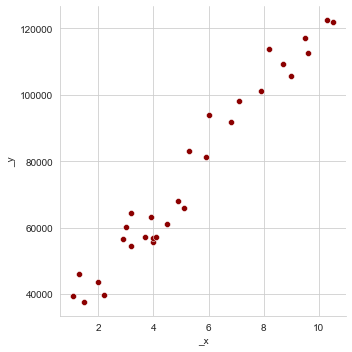

In [5]:
sns.relplot(data=df, x=x, y=y, color='darkred');  

In [6]:
Xc = sm.add_constant(x)

In [7]:
mod = sm.OLS(y, Xc)

In [8]:
res = mod.fit()

In [9]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     622.5
Date:                Thu, 28 Oct 2021   Prob (F-statistic):           1.14e-20
Time:                        19:59:54   Log-Likelihood:                -301.44
No. Observations:                  30   AIC:                             606.9
Df Residuals:                      28   BIC:                             609.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.579e+04   2273.053     11.347      0.000    2.11e+04    3.04e+04
x1          9449.9623    378.755     24.950      0.000    8674.119    1.02e+04
==============================================================================
Omnibus:                        2.140   Durbin-Watson:                   1.648
Prob(Omnibus):                  0.343   Jarque-Bera (JB):                1.569
Skew:                           0.363   Prob(JB):                        0.456
Kurtosis:                       2.147   Cond. No.                         13.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
print('Coefficient of determination: %.3f' %(res.rsquared))

Coefficient of determination: 0.957


In [11]:
eq = 'Model: ' + str(np.round(res.params[1],2)) + ' * YearsExperience + ' + str(np.round(res.params[0],2))
eq

'Model: 9449.96 * YearsExperience + 25792.2'

In [12]:
df['predict'] = res.predict()
df.head(3)

,YearsExperience,Salary,predict
0,1.1,39343,36187.158752
1,1.3,46205,38077.151217
2,1.5,37731,39967.143681


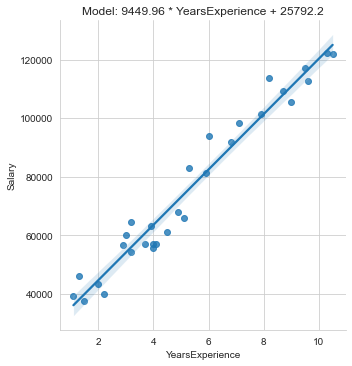

In [13]:
sns.lmplot(data=df, x='YearsExperience', y='Salary')
ax = plt.gca()
ax.set_title(eq);

## Bootstrapping Method

Let's perform a parametric resampling.

We are going to resample WITH replacement each row.

In [14]:
def bootSimpleReg(x, y, num_samples=10000, sample_size=100):
    '''
    It returns two list with the simple regression sample distribution: slopes and intercepts.
    '''
    slopeSD  = np.array([])
    intercSD = np.array([])
    x = pd.Series(x)
    y = pd.Series(y)
    xc = sm.add_constant(x)
    model = sm.OLS(y,xc)    #defining the model
    res = model.fit()       #fitting the model
    for k in range(num_samples):
        index = np.random.choice(x.index, replace=True, size=sample_size)
        xi = x[index].values
        yi = y[index].values
        xic = sm.add_constant(xi)
        modeli = sm.OLS(yi, xic)
        resi = modeli.fit()
        slopeSD  = np.append(slopeSD, resi.params[1])
        intercSD = np.append(intercSD, resi.params[0])
        plt.plot(xi, resi.predict(), color='grey', alpha=0.2)
    plt.scatter(x, y, color='darkred')
    plt.plot(x, res.predict(), linewidth=3, color='darkred')
    return(slopeSD, intercSD)  

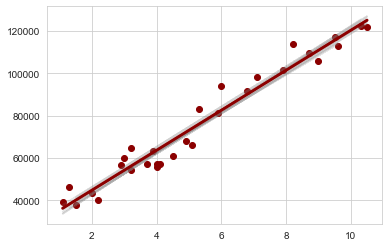

In [15]:
slopeSampDist, intercSampDist = bootSimpleReg(x, y, num_samples=10, sample_size=20)

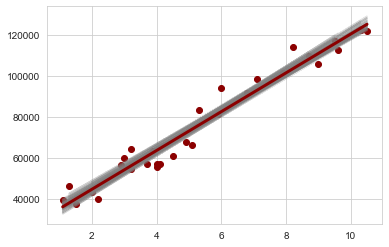

In [16]:
slopeSampDist, intercSampDist = bootSimpleReg(x, y, num_samples=100, sample_size=20)

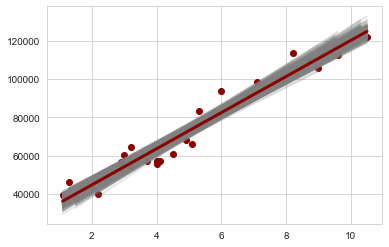

In [17]:
slopeSampDist, intercSampDist = bootSimpleReg(x, y, num_samples=1000, sample_size=20)

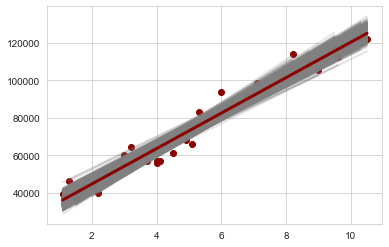

In [18]:
slopeSampDist, intercSampDist = bootSimpleReg(x, y, num_samples=10000, sample_size=20)

The bands are positioned more around the center of the data than at the edges because more data are concentrated at the center than at the edges.

In [19]:
def plotSampleDistribution(sampDist, title='Sample Distribution'):
    '''
    It plots the sample distribution
    '''
    sns.kdeplot(sampDist, shade=True, color='darkred').set(title=title)

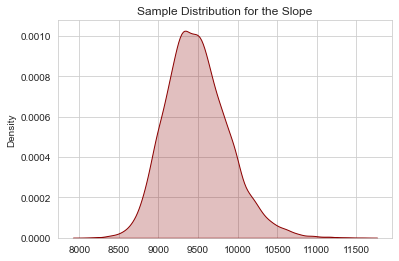

In [20]:
plotSampleDistribution(slopeSampDist, title='Sample Distribution for the Slope')

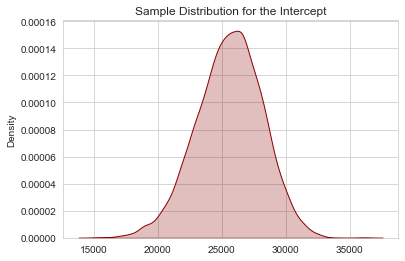

In [21]:
plotSampleDistribution(intercSampDist, title='Sample Distribution for the Intercept')

The graphs represent the sample distribution getting by bootstrap of slope and intercept. 

Let's apply a different type of bootstrapping, called non-parametric bootstrapping, whereby we use bootstrapping on the residuals and not the parameter itself.

## Non-parametric Bootstrapping

The idea here is to work with the residuals. Remember the errors or residuals are independent and identically distributed (IID) among our data.

In [22]:
df.head(3)

,YearsExperience,Salary,predict
0,1.1,39343,36187.158752
1,1.3,46205,38077.151217
2,1.5,37731,39967.143681


In [23]:
df['resids'] = res.resid
df.head(3)

,YearsExperience,Salary,predict,resids
0,1.1,39343,36187.158752,3155.841248
1,1.3,46205,38077.151217,8127.848783
2,1.5,37731,39967.143681,-2236.143681


Now we generate `num_samples` new sets of data by sampling the residuals WITH replacement and adding them to the fitted values.

In [24]:
def NPbootSimpleReg(x, y, num_samples=10000, sample_size=100):
    '''
    It returns two list with the simple regression sample distribution: slopes and intercepts.
    '''
    sample_size = len(x)
    slopeSD  = np.array([])
    intercSD = np.array([])
    xc = sm.add_constant(x)
    model = sm.OLS(y,xc)    # defining the model
    res = model.fit()       # fitting the model
    yPred = res.predict()   # predicted values
    resids = res.resid      # getting the residuals
    for k in range(num_samples):
        # create a sampling of the residuals with replacement
        boot_resids = np.random.choice(resids, sample_size, replace=True)
        newY = [yPredi + residi for yPredi, residi in zip(yPred, boot_resids)]
        modeli = sm.OLS(newY, xc)
        resi = modeli.fit()
        slopeSD  = np.append(slopeSD, resi.params[1])
        intercSD = np.append(intercSD, resi.params[0])
        plt.plot(x, resi.predict(), color='grey', alpha=0.2)
    plt.scatter(x, y, color='darkred')
    plt.plot(x, yPred, linewidth=3, color='darkred')
    return(slopeSD, intercSD)  

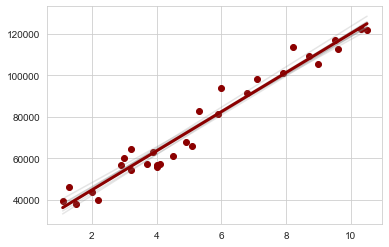

In [25]:
NPbootSimpleReg(x, y, num_samples=10);

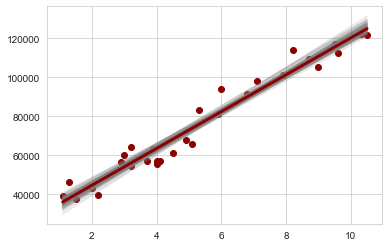

In [26]:
NPbootSimpleReg(x, y, num_samples=100);

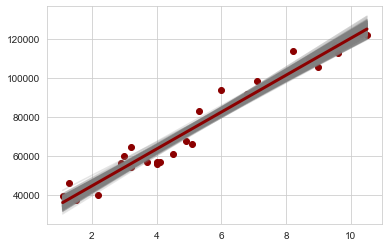

In [27]:
NPbootSimpleReg(x, y, num_samples=500);

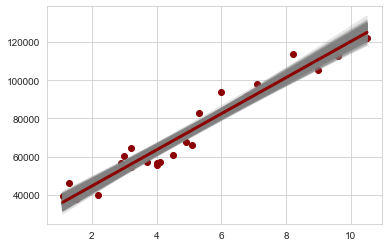

In [28]:
NPbootSimpleReg(x, y, num_samples=1000);

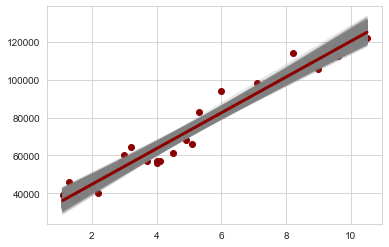

In [29]:
slope2, interc2 = NPbootSimpleReg(x, y, num_samples=10000)

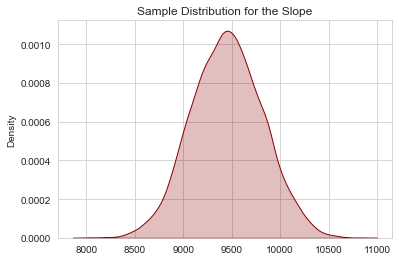

In [30]:
plotSampleDistribution(slope2, title='Sample Distribution for the Slope')

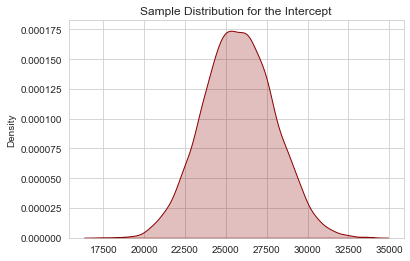

In [31]:
plotSampleDistribution(interc2, title='Sample Distribution for the Intercept')

References:

- https://towardsdatascience.com/linear-regression-with-bootstrapping-4924c05d2a9